# The porepy grid structure

In this tutorial we investigate the `porepy` grid structure, and exlain how to access information stored in the grid. 

## Basic grid construction

The simplest grids are Cartesian. `porepy` can create Cartesian grids in 1d, 2d, and 3d. In fact, there are 0d point-grids as well, but these are only used in the context of multiple intersecting fractures. To create a 2d Cartesian grid

In [1]:
import numpy as np
from porepy.grids import structured

nx = np.array([3, 2])
g = structured.CartGrid(nx)

The resulting cells will be of unit size, thus the grid covers the domain $[0, 3]\times [0,2]$. To specify the domain size, we need to pass a second argument

In [2]:
phys_dims = np.array([10, 10])
g_2 = structured.CartGrid(nx, phys_dims)

The grids currently only have node coordinates, together with topological information that we come back to below. To check the grid size, several attributes are provided

In [3]:
g.num_cells

6

In [4]:
g.num_faces

17

In [5]:
g.num_nodes

12

In [6]:
# And finally dimension
g.dim

2

The node coordinates are stored as 

In [7]:
g.nodes

array([[ 0.,  1.,  2.,  3.,  0.,  1.,  2.,  3.,  0.,  1.,  2.,  3.],
       [ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

and

In [8]:
g_2.nodes

array([[  0.        ,   3.33333333,   6.66666667,  10.        ,
          0.        ,   3.33333333,   6.66666667,  10.        ,
          0.        ,   3.33333333,   6.66666667,  10.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          5.        ,   5.        ,   5.        ,   5.        ,
         10.        ,  10.        ,  10.        ,  10.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]])

As expected the second grid covers a larger area.

We also see that even though the grids are 2d, the nodes have three coordinates. This is general, all geometric quantities in `porepy` have three dimensions, even if they represent objects that are genuinely lower-dimensional. The reason is that for fractured media, we will often work with grids on fracture surfaces that are embedded in 3d domains, and treating this as special cases throughout the code turned out to be overly cumbersome. Also note that the third dimension was introduced automatically, so the user need not worry about this. 

# Geometric quantities

To compute additional geometric quantities, grids come with a method `compute_geometry()`, that will add attributes `cell_centers`, `face_centers` and `face_normals`:

In [9]:
g.compute_geometry()
print(g.cell_centers)

[[ 0.5  1.5  2.5  0.5  1.5  2.5]
 [ 0.5  0.5  0.5  1.5  1.5  1.5]
 [ 0.   0.   0.   0.   0.   0. ]]


And similar for face information. It is of course possible to set the geometric quantities manually. Be aware that a subsequent call to `compute_geometry()` will overwrite this information.

It is sometimes useful to consider grids with a Cartesian topology, but with perturbed geometry. This is simply achieved by perturbing the nodes, and then (re)-computing geometry:

In [10]:
g_2.compute_geometry()
print(g_2.cell_centers)
g_2.nodes = g_2.nodes + np.random.random((g_2.nodes.shape))
g_2.compute_geometry()
print(g_2.cell_centers)

[[ 1.66666667  5.          8.33333333  1.66666667  5.          8.33333333]
 [ 2.5         2.5         2.5         7.5         7.5         7.5       ]
 [ 0.          0.          0.          0.          0.          0.        ]]
[[ 2.00090998  5.39165564  8.64254323  2.28054361  5.51486782  8.78886741]
 [ 3.16265892  2.94723049  3.16883664  7.83656599  8.03393894  7.78043754]
 [ 0.57011113  0.61439371  0.53899702  0.63377647  0.75976531  0.73275399]]


When perturbing nodes, make sure to limit the distortion so that the grid topology still is valid; if not, all kinds of problems may arise.

## Visualization

`porepy` provides two ways of visualizing the grid, matplotlib and vtk/paraview. Matplotlib visualization is done by

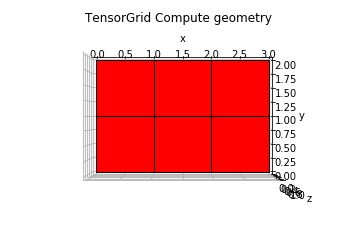

In [11]:
%matplotlib inline
from porepy.viz import plot_grid
plot_grid.plot_grid(g)

As we see, the plot is in 3d, and the third axis adds noise to the plot. The matplotlib interface is most useful for quick visualization, e.g. during debuging. For instance, we can add cell numbers to the plot by writing

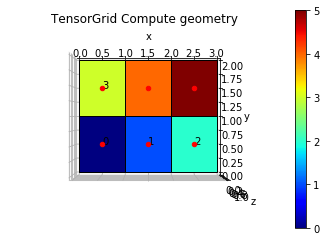

In [12]:
cell_id = np.arange(g.num_cells)
plot_grid.plot_grid(g, cell_value=cell_id, info='c')

For further information, see the documentation of `plot_grid`.

The second visualization option dumps the grid to the vtk (or rather vtu; the grids are considered unstructured):

In [13]:
from porepy.viz import exporter
exporter.export_vtk(g, 'grid')

This file can then be accessed by e.g. paraview. Again, see `export_vtk()` for further documentation.

# Topological information

In addition to storing coordinates of cells, faces and nodes, the grid object also keeps track of the relation between them. Specifically, we can access:
1. The relation between cells and faces
2. The relation between faces and nodes
3. The direction of `face_normals`, as in which of the neighboring cells has the normal vector as outwards pointing.

Note that there is no notion of edges for 3d grids. These are not usually needed for the type of numerical methods that are primarily of interest in `porepy`. The information can still be recovered from the face-node relations, see comments below.

The topological information is stored in two attributes, `cell_faces` and `face_nodes`. The latter has the simplest interpretation, so we start out with that one:

In [14]:
g.face_nodes

<12x17 sparse matrix of type '<class 'numpy.bool_'>'
	with 34 stored elements in Compressed Sparse Column format>

We see that the information is stored as a scipy.sparse matrix. From the shape of the matrix, we conclude that the rows represent nodes, while the faces are stored in columns. We can get the nodes for the first face by brute force by writing

In [15]:
np.where(g.face_nodes[:, 0].toarray())[0]

array([0, 4])

That was hardly elegant, though, and would make for cumbersome implementation of, say, a numerical method. A better approach is to utilize the csc storage format, and write

In [16]:
g.face_nodes.indices[g.face_nodes.indptr[0] : g.face_nodes.indptr[1]]

array([0, 4], dtype=int32)

To see why this works, confer the scipy.sparse documentation. Getting the faces of a node can be done by converting `g.face_nodes` to a csr_matrix, and then follow the above procedure.



The map between cells and faces is stored in the same way, thus the faces of cell 0 is found by

In [17]:
faces_of_cell_0 = g.cell_faces.indices[g.cell_faces.indptr[0] : g.cell_faces.indptr[1]]
print(faces_of_cell_0)

[ 0  1  8 11]


However, `cell_faces` also keeps track of the direction of the normal vector relative to the neighboring cells, by storing data as $\pm 1$, or zero if there is no connection between the cells (in contrast, `face_nodes` simply consist of '`True` or `False`).

In [18]:
g.cell_faces.data[g.cell_faces.indptr[0] : g.cell_faces.indptr[1]]

array([-1.,  1., -1.,  1.])

Compare this with the face normal vectors

In [19]:
g.face_normals[:, faces_of_cell_0]

array([[ 1.,  1., -0., -0.],
       [-0., -0.,  1.,  1.],
       [ 0.,  0., -0., -0.]])

We observe that positive data corresponds to normal vector pointing out of the cell. This is a very useful feature, since it in effect means that the transpose of `g.cell_faces` is the discrete divergence operator for the grid.

As with the face-node relations, we can obtain the cells of a face by representing the matrix in a sparse row storage format, and then use the above procedure of indices and index pointers. However, we know that there will be either 1 or 2 cells adjacent to each face. It is thus feasible to create a dense representation of the cell-face relations:

In [20]:
g.cell_face_as_dense()

array([[-1,  0,  1,  2, -1,  3,  4,  5, -1, -1, -1,  0,  1,  2,  3,  4,  5],
       [ 0,  1,  2, -1,  3,  4,  5, -1,  0,  1,  2,  3,  4,  5, -1, -1, -1]])

Here, each column represent the cells of a face, and negative values signifies that the face is on the boundary. The cells are ordered so that the normal vector points from the cell in row 0 to row 1.

Finally, we note that to get a cell-node relation, we can combine `cell_faces` and `face_nodes`. However, since `cell_faces` contains both positive and negative values, we need to take the absolute value of the data (without modifying `cell_faces` directly, since we may want to use the divergence operator later). This procedure is implemented in the method `cell_nodes()`, which returns a sparse matrix that can be handled in the usual way

In [21]:
cn = g.cell_nodes()
cn.indices[cn.indptr[0] : cn.indptr[1]]

array([0, 1, 4, 5], dtype=int32)

# Simplex grids


`porepy` has grid constructors for Cartesian grids in 2d and 3d, as well as simplex grids in 2d and 3d. The simplex grids can be specified either by point coordinates and a cell-node map (e.g. a Delaunay triangulation), or simply by the node coordinates. In the latter case, the Delaunay triangulation (or the 3d equivalent) will be used to construct the grid.

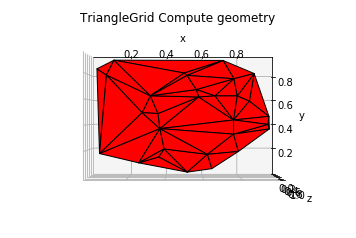

In [22]:
from porepy.grids import simplex
nodes = np.random.random((2, 30))
g = simplex.TriangleGrid(nodes)
g.compute_geometry()
plot_grid.plot_grid(g)

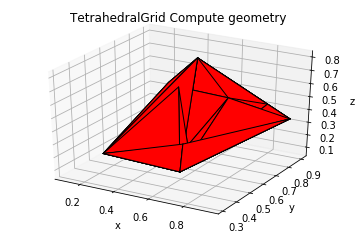

In [23]:
g_3d = simplex.TetrahedralGrid(np.random.random((3, 10)))
g_3d.compute_geometry()
plot_grid.plot_grid(g_3d)

A structured triangular grid (squares divided into two) is also provided:

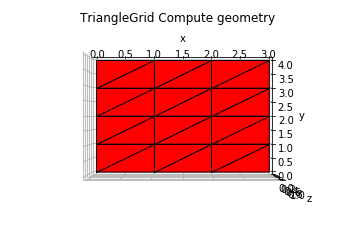

In [24]:
g = simplex.StructuredTriangleGrid(np.array([3, 4]))
g.compute_geometry()
plot_grid.plot_grid(g)

# Import of grids from external meshing tools

Currently, `porepy` supports import of grids from GMSH. This is mostly used for fractured domains (tutorial still to be made).

The grid structure in `porepy` is fairly general, and can support a much wider class of grids than those currently implemented. To import a new type of grid, all that is needed is to construct the face-node and cell-face maps, together with importing the node coordinates. Remaining geometric attributes can then be calculated by the `compute_geometry()` function. 

When implementing such a filter, note that the geometry computation tacitly *assumes an ordering of the nodes in each face*, in the sense that the edges of the faces are found by joining subsequent nodes in the face-node list. To illustrate the danger, consider the following example

Cell volume 0.625


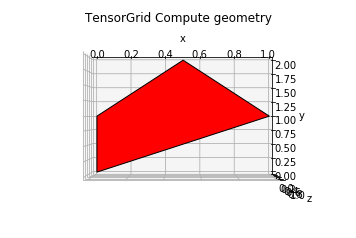

In [25]:
g = structured.CartGrid([1, 1])

# Move the second node so that the implicit edges are intersecting
g.nodes[0, 1] = 0.5
g.nodes[1, 1] = 2
g.compute_geometry()
# Print the cell volume, as computed
print('Cell volume ' + str(g.cell_volumes[0]))
# A short calculation will show that the actual cell volume is 1. 

plot_grid.plot_grid(g)

For more complex grids, errors in the node ordering may also lead to error messages / assertion errors in the geometry computation.